---
## Homework | Tarea

¡Ahora es tu turno de procesar datos gravimétricos!

Para ello vamos a usar un conjunto de datos gravimétricos sobre Alice Springs, Australia.
Puedes encontrar este archivo en https://raw.githubusercontent.com/santisoler/coco-fatiando-tutorial/homework/homework_data/australia_gravity.csv.
La suma de comprobación (hash) de ese archivo es: `sha256:b0f44e5b523a3ca034d07820022c23e5b65875956a88e6eda4cd69f9b66da9fc`

El objetivo es escribir un nuevo notebook en el cual se realicen las siguientes tareas:

1. Importar las librerías necesarias para descargar, procesar y graficar los datos.
1. Descargar los datos gravimétricos de Alice Springs utilizando Pooch.
1. Descargar la grilla de topografía presente en el archivo `earth-topography-10arcmin.nc` (doi: 10.5281/zenodo.5167357) utilizando Pooch.
1. Cargar los datos gravimétricos con Pandas y la grilla de topografía con Xarray.
1. Recortar la grilla de topografía a la región de los datos gravimétricos, incluyendo 5 grados de padding a cada lado.
    > Ayuda: podemos utilizar la función `verde.get_region()` para obtener la región de un conjunto de coordenadas, y luego `verde.pad_region()` para agregar padding a la región.
1. Proyectar los datos gravimétricos y la grilla de topografía utilizando una proyección de tipo Mercator, con la latitud central ubicada en la latitud media de los datos.
1. Calcular el **disturbio de gravedad** quitando la gravedad normal de los datos observados. Para ello, calcula la gravedad normal generada por el elipsoide WGS84 mediante Boule.
1. Calcula el **efecto gravitatorio de la topografía** mediante Harmonica. Utiliza la mismas densidades que elegimos en este notebook. Calcula luego la **gravedad de Bouguer** como la diferencia entre el **disturbio de gravedad** y el **efecto topográfico**.
1. Separa la gravedad de Bouguer en el **campo regional** y el **campo residual**. Puedes calcular el campo regional mediante fuentes equivalentes (`harmonica.EquivalentSources`) profundas.
1. **Grilla** el campo residual en una grilla regular a una altitud de 1300m y con una resolución de 9km.

Finalmente, **crea un repositorio** `coco-fatiando-2022` en tu cuenta de GitHub y sube el notebook que escribiste.

Puedes graficar los datos a medida que vas realizando las tareas. Además, recomendamos agregar cada nuevo cálculo al DataFrame de datos y escribir celdas Markdown en las que detalles brevemente qué realizas en las celdas de código.

## Importando paquetes

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
import xarray as xr

In [3]:
import pyproj

In [4]:
import pooch
import verde as vd
import boule as bl
import harmonica as hm

## Descargando y cargando datos

**Datos de gravimetria**
No funcionaba el link por lo que lei los datos desde la carpeta del repo

In [28]:
# Ruta al archivo
data_folder = Path(".") / "homework_data"

# Abrimos el archivo
gravimetria = pd.read_csv(data_folder / "australia_gravity.csv") #cargo el archivo con Pandas

In [29]:
gravimetria.head() #vemos la estructura del archivo, primeras 5 filas

,longitude,latitude,height,gravity
0,128.044657,-25.967222,506.670,978883.620
1,128.126386,-25.973100,520.380,978873.000
2,128.206151,-25.975900,527.905,978872.285
3,128.300509,-25.969732,545.220,978872.120
4,128.375399,-25.969807,559.490,978871.120


**Datos topograficos** Lectura desde doi

In [30]:
doi = "10.5281/zenodo.5167357"

In [31]:
topografia = f"doi:{doi}/earth-topography-10arcmin.nc"
topografia_hash = "md5:c43b61322e03669c4313ba3d9a58028d"



In [32]:
path_topografia = pooch.retrieve(topografia, known_hash=topografia_hash, progressbar=True)
path_topografia

'/home/jupyter-gisela.moran@mi.un-86bdd/.cache/pooch/cfd6d849435e1ca109cf31d2dae3fe32-earth-topography-10arcmin.nc'

**Cargando datos gravimetricos**

In [33]:
data_topo = xr.load_dataarray(path_topografia)
data_topo

<xarray.DataArray 'topography' (latitude: 1081, longitude: 2161)>
array([[ 2742.,  2742.,  2742., ...,  2742.,  2742.,  2742.],
       [ 2768.,  2768.,  2768., ...,  2768.,  2768.,  2768.],
       [ 2822.,  2822.,  2821., ...,  2822.,  2822.,  2822.],
       ...,
       [-4243., -4244., -4245., ..., -4242., -4243., -4243.],
       [-4156., -4157., -4157., ..., -4156., -4156., -4156.],
       [-4237., -4237., -4237., ..., -4237., -4237., -4237.]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Recortando la grilla 

In [46]:
inside_points = vd.inside((data.longitude, data.latitude), region)

data = data[inside_points]
data

,longitude,latitude,height,gravity
1108,128.026316,-24.971932,526.950,978770.810
1109,128.151315,-24.951930,543.420,978762.120
1110,128.275064,-24.951100,564.290,978766.500
1111,128.347984,-24.950269,607.440,978756.690
1112,128.462983,-24.953598,580.040,978758.690
...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630
6571,134.713019,-20.048295,383.870,978536.595
6572,134.789628,-20.049179,386.170,978542.880
6573,134.866175,-20.049672,358.170,978555.905


In [47]:
region=(128, 135, -24, -20)

In [48]:
region_pad = vd.pad_region(region, pad=5)
region_pad

(123, 140, -29, -15)

In [50]:
data_topo = data_topo.sel(
    longitude=slice(region_pad[0], region_pad[1]),
    latitude=slice(region_pad[2], region_pad[3])
)
data_topo

<xarray.DataArray 'topography' (latitude: 85, longitude: 103)>
array([[455., 438., 433., ...,  16.,  19.,  25.],
       [457., 447., 449., ...,  25.,  24.,  28.],
       [468., 470., 480., ...,  30.,  27.,  31.],
       ...,
       [-63., -40., -31., ..., -23., -24., -24.],
       [-72., -65., -53., ..., -31., -32., -33.],
       [-60., -71., -62., ..., -32., -34., -34.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 123.0 123.2 123.3 123.5 ... 139.7 139.8 140.0
  * latitude   (latitude) float64 -29.0 -28.83 -28.67 ... -15.33 -15.17 -15.0
Attributes:
    Conventions:     CF-1.8
    title:           Topographic and bathymetric height of ETOPO1 (ice surfac...
    crs:             WGS84
    source:          Generated from a spherical harmonic model by the ICGEM C...
    license:         public domain
    references:      https://doi.org/10.7289/V5C8276M
    long_name:       topographic height above mean sea level
    standard_name:   height_above_mean_sea_level
    description:     height topography/bathymetry referenced to mean sea level
    units:           m
    actual_range:    [-10023.   6082.]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

## Ploteo los datos

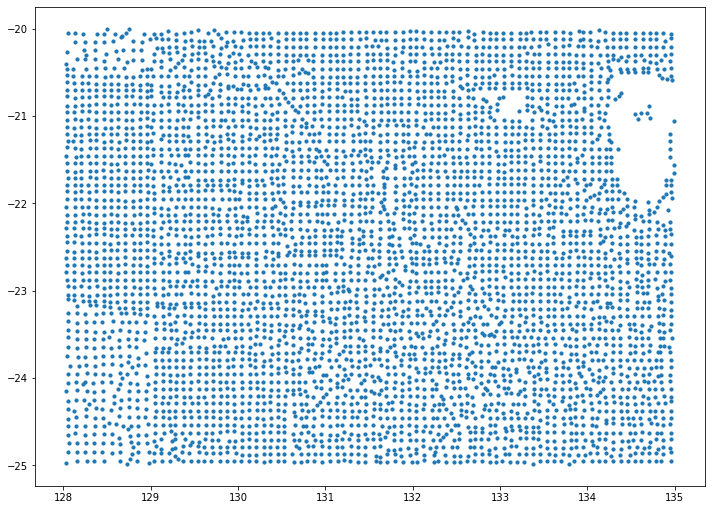

In [52]:
plt.figure(figsize=(12, 12))
plt.scatter(data.longitude, data.latitude, s=10)
plt.gca().set_aspect("equal")
plt.show()

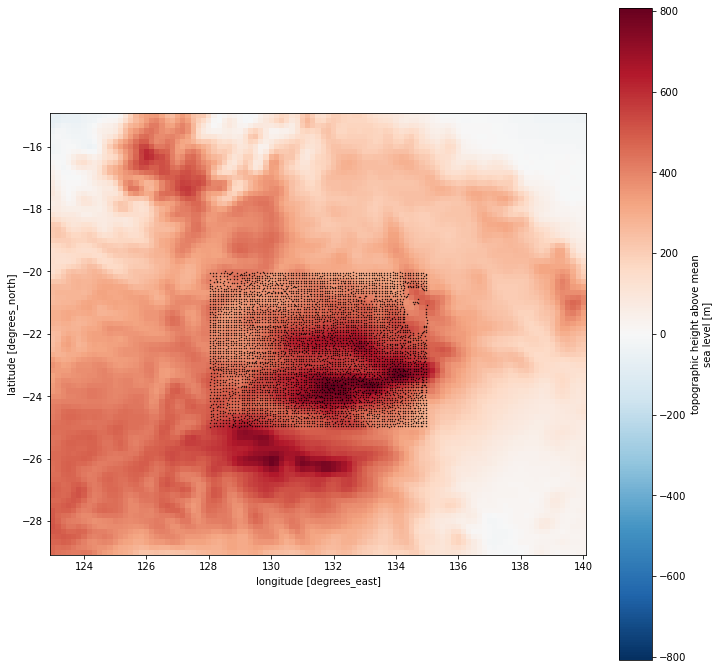

In [59]:
plt.figure(figsize=(12, 12))
data_topo.plot()
plt.scatter(data.longitude, data.latitude, c="black", s=0.2)
plt.gca().set_aspect("equal")
plt.show()

## Proyectando los datos

In [56]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [57]:
easting, northing = projection(data.longitude.values, data.latitude.values)
data = data.assign(easting_m=easting, northing_m=northing)
data

,longitude,latitude,height,gravity,easting_m,northing_m
1108,128.026316,-24.971932,526.950,978770.810,1.317151e+07,-2.637906e+06
1109,128.151315,-24.951930,543.420,978762.120,1.318437e+07,-2.635649e+06
1110,128.275064,-24.951100,564.290,978766.500,1.319710e+07,-2.635555e+06
1111,128.347984,-24.950269,607.440,978756.690,1.320460e+07,-2.635461e+06
1112,128.462983,-24.953598,580.040,978758.690,1.321644e+07,-2.635837e+06
...,...,...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630,1.385147e+07,-2.092651e+06
6571,134.713019,-20.048295,383.870,978536.595,1.385945e+07,-2.092488e+06
6572,134.789628,-20.049179,386.170,978542.880,1.386733e+07,-2.092584e+06
6573,134.866175,-20.049672,358.170,978555.905,1.387520e+07,-2.092638e+06


In [60]:
topografia_proj = vd.project_grid(data_topo, projection, method="nearest")
topografia_proj

<xarray.DataArray 'topography' (northing: 85, easting: 103)>
array([[446.5, 446.5, 433. , ...,  16. ,  19. ,  25. ],
       [452. , 452. , 449. , ...,  25. ,  24. ,  28. ],
       [469. , 469. , 480. , ...,  30. ,  27. ,  31. ],
       ...,
       [-51.5, -51.5, -31. , ..., -23. , -24. , -24. ],
       [-67. , -67. , -57.5, ..., -31.5, -33. , -33.5],
       [-67. , -67. , -57.5, ..., -31.5, -33. , -33.5]], dtype=float32)
Coordinates:
  * easting   (easting) float64 1.265e+07 1.267e+07 ... 1.439e+07 1.44e+07
  * northing  (northing) float64 -3.101e+06 -3.082e+06 ... -1.569e+06 -1.551e+06
Attributes:
    metadata:  Generated by Chain(steps=[('mean',\n              BlockReduce(...

## Calculando el disturbio de gravedad

In [62]:
ellipsoid = bl.WGS84
ellipsoid

Ellipsoid(name='WGS84', semimajor_axis=6378137, flattening=0.0033528106647474805, geocentric_grav_const=398600441800000.0, angular_velocity=7.292115e-05, long_name='World Geodetic System 1984', reference='Hofmann-Wellenhof, B., & Moritz, H. (2006). Physical Geodesy (2nd, corr. ed. 2006 edition ed.). Wien\u202f; New York: Springer.')

In [64]:
normal_gravity = ellipsoid.normal_gravity(data.latitude, data.height)
normal_gravity

1108    978790.827751
1109    978784.363282
1110    978777.865018
1111    978764.490875
1112    978773.176786
            ...      
6570    978518.114308
6571    978521.112645
6572    978520.454091
6573    978529.125611
6574    978535.600609
Length: 4827, dtype: float64

In [66]:
gravity_disturbance = data.gravity - normal_gravity

data = data.assign(gravity_disturbance_mgal=gravity_disturbance)
data

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal
1108,128.026316,-24.971932,526.950,978770.810,1.317151e+07,-2.637906e+06,-20.017751
1109,128.151315,-24.951930,543.420,978762.120,1.318437e+07,-2.635649e+06,-22.243282
1110,128.275064,-24.951100,564.290,978766.500,1.319710e+07,-2.635555e+06,-11.365018
1111,128.347984,-24.950269,607.440,978756.690,1.320460e+07,-2.635461e+06,-7.800875
1112,128.462983,-24.953598,580.040,978758.690,1.321644e+07,-2.635837e+06,-14.486786
...,...,...,...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630,1.385147e+07,-2.092651e+06,18.515692
6571,134.713019,-20.048295,383.870,978536.595,1.385945e+07,-2.092488e+06,15.482355
6572,134.789628,-20.049179,386.170,978542.880,1.386733e+07,-2.092584e+06,22.425909
6573,134.866175,-20.049672,358.170,978555.905,1.387520e+07,-2.092638e+06,26.779389


## Calculando efecto gravitatorio de la topografia

In [68]:
density = np.where(topografia_proj > 0, 2670, 1040 - 2670)

topography_model = hm.prism_layer(
    coordinates=(topografia_proj.easting, topografia_proj.northing),
    surface=topografia_proj,
    reference=0,
    properties={"density": density},
)
topography_model

<xarray.Dataset>
Dimensions:   (northing: 85, easting: 103)
Coordinates:
  * easting   (easting) float64 1.265e+07 1.267e+07 ... 1.439e+07 1.44e+07
  * northing  (northing) float64 -3.101e+06 -3.082e+06 ... -1.569e+06 -1.551e+06
    top       (northing, easting) float32 446.5 446.5 433.0 ... 0.0 0.0 0.0
    bottom    (northing, easting) float64 0.0 0.0 0.0 0.0 ... -31.5 -33.0 -33.5
Data variables:
    density   (northing, easting) int64 2670 2670 2670 ... -1630 -1630 -1630
Attributes:
    coords_units:      meters
    properties_units:  SI

In [69]:
coordinates = (data.easting_m, data.northing_m, data.height)

terrain_effect = topography_model.prism_layer.gravity(coordinates, field="g_z")
terrain_effect

array([56.70948774, 55.65370084, 60.31337574, ..., 35.38049856,
       35.35656756, 32.82511189])

In [70]:
data = data.assign(terrain_effect_mgal=terrain_effect)
data

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal
1108,128.026316,-24.971932,526.950,978770.810,1.317151e+07,-2.637906e+06,-20.017751,56.709488
1109,128.151315,-24.951930,543.420,978762.120,1.318437e+07,-2.635649e+06,-22.243282,55.653701
1110,128.275064,-24.951100,564.290,978766.500,1.319710e+07,-2.635555e+06,-11.365018,60.313376
1111,128.347984,-24.950269,607.440,978756.690,1.320460e+07,-2.635461e+06,-7.800875,65.940728
1112,128.462983,-24.953598,580.040,978758.690,1.321644e+07,-2.635837e+06,-14.486786,60.653042
...,...,...,...,...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630,1.385147e+07,-2.092651e+06,18.515692,40.889583
6571,134.713019,-20.048295,383.870,978536.595,1.385945e+07,-2.092488e+06,15.482355,40.875899
6572,134.789628,-20.049179,386.170,978542.880,1.386733e+07,-2.092584e+06,22.425909,35.380499
6573,134.866175,-20.049672,358.170,978555.905,1.387520e+07,-2.092638e+06,26.779389,35.356568


In [71]:
gravity_bouguer = data.gravity_disturbance_mgal - data.terrain_effect_mgal

data = data.assign(gravity_bouguer_mgal=gravity_bouguer)
data

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal
1108,128.026316,-24.971932,526.950,978770.810,1.317151e+07,-2.637906e+06,-20.017751,56.709488,-76.727239
1109,128.151315,-24.951930,543.420,978762.120,1.318437e+07,-2.635649e+06,-22.243282,55.653701,-77.896983
1110,128.275064,-24.951100,564.290,978766.500,1.319710e+07,-2.635555e+06,-11.365018,60.313376,-71.678393
1111,128.347984,-24.950269,607.440,978756.690,1.320460e+07,-2.635461e+06,-7.800875,65.940728,-73.741603
1112,128.462983,-24.953598,580.040,978758.690,1.321644e+07,-2.635837e+06,-14.486786,60.653042,-75.139829
...,...,...,...,...,...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630,1.385147e+07,-2.092651e+06,18.515692,40.889583,-22.373890
6571,134.713019,-20.048295,383.870,978536.595,1.385945e+07,-2.092488e+06,15.482355,40.875899,-25.393544
6572,134.789628,-20.049179,386.170,978542.880,1.386733e+07,-2.092584e+06,22.425909,35.380499,-12.954590
6573,134.866175,-20.049672,358.170,978555.905,1.387520e+07,-2.092638e+06,26.779389,35.356568,-8.577179


In [73]:
def scatter_plot_gravity(easting, northing, gravity_data, title=None):
    """
    Generate scatter plots of gravity data
    
    The colorbar will be centered around cero and using the seismic colormap.
    
    Parameters
    ----------
    easting: array
        Easting coordinates of the gravity data in meters.
    northing : array
        Northing coordinates of the gravity data in meters.
    gravity_data : array
        Values of the gravity data in mgal.
    title : str (optional)
        Title of the plot.
    """
    maxabs = vd.maxabs(gravity_data)
    plt.figure(figsize=(12, 12))
    plt.scatter(
        easting,
        northing,
        c=gravity_data,
        s=10,
        cmap="seismic",
        vmin=-maxabs,
        vmax=maxabs,
    )
    plt.xlabel("easting [m]")
    plt.ylabel("northing [m]")
    if title is not None:
        plt.title(title)
    plt.colorbar(label="mGal", shrink=0.6)
    plt.gca().set_aspect("equal")

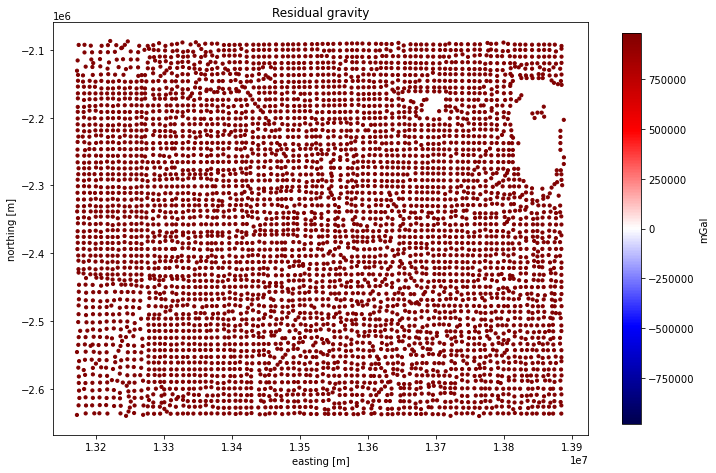

In [75]:
scatter_plot_gravity(
    data.easting_m,
    data.northing_m,
    data.gravity,
    title="Residual gravity",
)

## Campo regional y campo residual

In [77]:
deep_sources = hm.EquivalentSources(damping=1000, depth=500e3)

In [78]:
coordinates = (data.easting_m, data.northing_m, data.height)

deep_sources.fit(coordinates, data.gravity_bouguer_mgal)

/opt/tljh/user/envs/coco-projects/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=1000, depth=500000.0)

In [79]:
gravity_regional = deep_sources.predict(coordinates)

data = data.assign(gravity_regional_mgal=gravity_regional)
data

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal
1108,128.026316,-24.971932,526.950,978770.810,1.317151e+07,-2.637906e+06,-20.017751,56.709488,-76.727239,-63.661335
1109,128.151315,-24.951930,543.420,978762.120,1.318437e+07,-2.635649e+06,-22.243282,55.653701,-77.896983,-65.344983
1110,128.275064,-24.951100,564.290,978766.500,1.319710e+07,-2.635555e+06,-11.365018,60.313376,-71.678393,-67.089501
1111,128.347984,-24.950269,607.440,978756.690,1.320460e+07,-2.635461e+06,-7.800875,65.940728,-73.741603,-68.133571
1112,128.462983,-24.953598,580.040,978758.690,1.321644e+07,-2.635837e+06,-14.486786,60.653042,-75.139829,-69.825918
...,...,...,...,...,...,...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630,1.385147e+07,-2.092651e+06,18.515692,40.889583,-22.373890,-25.916255
6571,134.713019,-20.048295,383.870,978536.595,1.385945e+07,-2.092488e+06,15.482355,40.875899,-25.393544,-25.312068
6572,134.789628,-20.049179,386.170,978542.880,1.386733e+07,-2.092584e+06,22.425909,35.380499,-12.954590,-24.711275
6573,134.866175,-20.049672,358.170,978555.905,1.387520e+07,-2.092638e+06,26.779389,35.356568,-8.577179,-24.123643


In [80]:
gravity_residual = data.gravity_bouguer_mgal - gravity_regional

data = data.assign(gravity_residual_mgal=gravity_residual)
data

,longitude,latitude,height,gravity,easting_m,northing_m,gravity_disturbance_mgal,terrain_effect_mgal,gravity_bouguer_mgal,gravity_regional_mgal,gravity_residual_mgal
1108,128.026316,-24.971932,526.950,978770.810,1.317151e+07,-2.637906e+06,-20.017751,56.709488,-76.727239,-63.661335,-13.065904
1109,128.151315,-24.951930,543.420,978762.120,1.318437e+07,-2.635649e+06,-22.243282,55.653701,-77.896983,-65.344983,-12.552000
1110,128.275064,-24.951100,564.290,978766.500,1.319710e+07,-2.635555e+06,-11.365018,60.313376,-71.678393,-67.089501,-4.588892
1111,128.347984,-24.950269,607.440,978756.690,1.320460e+07,-2.635461e+06,-7.800875,65.940728,-73.741603,-68.133571,-5.608031
1112,128.462983,-24.953598,580.040,978758.690,1.321644e+07,-2.635837e+06,-14.486786,60.653042,-75.139829,-69.825918,-5.313910
...,...,...,...,...,...,...,...,...,...,...,...
6570,134.635489,-20.049789,393.865,978536.630,1.385147e+07,-2.092651e+06,18.515692,40.889583,-22.373890,-25.916255,3.542365
6571,134.713019,-20.048295,383.870,978536.595,1.385945e+07,-2.092488e+06,15.482355,40.875899,-25.393544,-25.312068,-0.081476
6572,134.789628,-20.049179,386.170,978542.880,1.386733e+07,-2.092584e+06,22.425909,35.380499,-12.954590,-24.711275,11.756686
6573,134.866175,-20.049672,358.170,978555.905,1.387520e+07,-2.092638e+06,26.779389,35.356568,-8.577179,-24.123643,15.546464


## Grillado

In [81]:
eqs = hm.EquivalentSources(damping=10, depth=10e3)

coordinates = (data.easting_m, data.northing_m, data.height)
eqs.fit(coordinates, data.gravity_residual_mgal)

/opt/tljh/user/envs/coco-projects/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


EquivalentSources(damping=10, depth=10000.0)

In [82]:
residual_grid = eqs.grid(
    upward=2200,  # height in meters
    spacing=3000,  # spacing in meters
    data_names=["gravity_residual"],
)
residual_grid

<xarray.Dataset>
Dimensions:           (northing: 185, easting: 240)
Coordinates:
  * easting           (easting) float64 1.317e+07 1.317e+07 ... 1.389e+07
  * northing          (northing) float64 -2.64e+06 -2.637e+06 ... -2.087e+06
    upward            (northing, easting) float64 2.2e+03 2.2e+03 ... 2.2e+03
Data variables:
    gravity_residual  (northing, easting) float64 -11.49 -11.81 ... 13.26 12.34
Attributes:
    metadata:  Generated by EquivalentSources(damping=10, depth=10000.0)

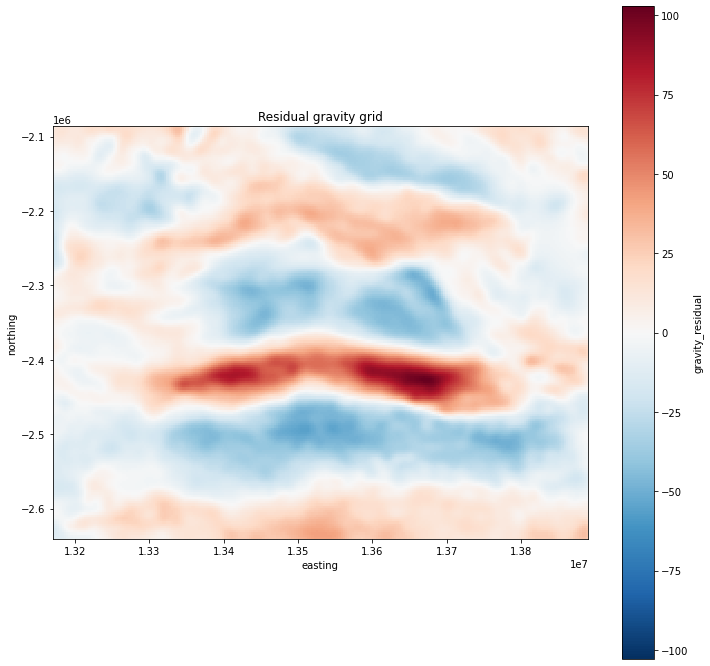

In [83]:
plt.figure(figsize=(12, 12))
residual_grid.gravity_residual.plot()
plt.title("Residual gravity grid")
plt.gca().set_aspect("equal")
plt.show()